# Third assignment: Social contagion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import collections, itertools
#import cv2,os 
import plotly 
plotly.tools.set_credentials_file(username='franco.danilo', api_key='ecMyRQ2GXo5ZASr8AgFu')

import plotly.plotly as py
import plotly.graph_objs as go

from random import choice
from networkx.algorithms import community

#from networkx.algorithms.community.quality import modularity
#from networkx.algorithms import community
#from networkx.algorithms.community import greedy_modularity_communities

## 0. Contagion utilities definitions

In [128]:
def init_labels(graph):
    labels={}
    for node in graph.nodes():
        labels[node] = 'b'
    return labels

def susceptibleList(labeledNodes):
    return [k for k,v in labeledNodes.items() if v=='b']

def spread_contagion(labeledNodes, decisionPO, verbose=False):
    i = 1
    changed = 0
    
    while True:
        current = list(labeledNodes.values())
        susc = susceptibleList(labeledNodes)
        
        for node in susc:            
            edgelist = []
            for pair in list(G.edges()):
                if node not in pair:
                    continue
                edgelist.append(pair[1] if pair[0]==node else pair[0])
            
            num_neigb = len(edgelist)
            infct_neigb = len([friend for friend in edgelist if labeledNodes[friend]=='r'])
                    
            if num_neigb != 0 and infct_neigb/num_neigb >= decisionPO:
                labeledNodes[node]='r'
                susc.remove(node)
                changed += 1
                
        if verbose:
            plt.figure(figsize=(15,8))
            plt.title("iteration {}: #Susceptible:{}, #Infected:{}"
                      .format(i,len(susc),len(labeledNodes)-len(susc)))
            nx.draw_networkx(G, pos, node_color=labeledNodes.values(), font_size=10, node_size=80) 

        if current==list(labeledNodes.values()): break
        
        i+=1
    return changed
        
def graph_infection(labeledNodes, rankedInfectList):
    susc = susceptibleList(labeledNodes)
    while True:
        node,_ = rankedInfectList.pop(0)
        if node in susc:
            labeledNodes[node]='r'
            break
    return node
        
def evaluate_spread(graph, payOffMatrix_dict, toBeInfected, verbose=False):
    suscPerIter = {}
    for setting, mtrx in payOffMatrix_dict.items():
        
        if verbose: print(setting)
            
        remaining_list = toBeInfected.copy()
        labels = init_labels(graph)
        suscPerIter[setting]=[[],[]]
        
        while True:
            susc = susceptibleList(labels)
            suscPerIter[setting][0].append(len(susc))
            
            if len(susc)==0: break
                
            infct_node = graph_infection(labels, remaining_list)
            infct_influence = spread_contagion(labels, mtrx[1,1]/(mtrx[0,0]+mtrx[1,1]), verbose)
            
            if verbose: print("\t {} infected {} nodes".format(infct_node, infct_influence))
                
            suscPerIter[setting][1].append((infct_node,infct_influence))
    return suscPerIter

def plot_distribution(distrDict, title):
    layout = go.Layout(
        title=go.layout.Title(text=title),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(text="# infections")
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(text="# susceptibles")
        )
    )
    
    data = []
    for setting, suscList in distrDict.items():
        sizes = list(map(lambda pair:pair[1],suscList[1]))
        
        trace = go.Scatter(
            y=suscList[0],
            name=setting,
            text=list(map(lambda pair: "'{}' infected {}".format(pair[0],pair[1]),suscList[1])),#suscList[1],
            marker=dict(
                size=sizes,
                sizemode='area',
                sizeref=2.*max(sizes)/(50.**2),
                sizemin=5
            )
        )
        data.append(trace)
        
    return py.iplot(go.Figure(data=data, layout=layout), filename=title)

### -- Random infection 

In [129]:
def random_ranking(graph):
    return list(zip(np.random.permutation(graph.nodes()),range(graph.number_of_nodes())))

### -- Nodes-measure guided infections

In [130]:
def metric_ranking(metricFunction, graph):
    return sorted(dict(metricFunction(graph)).items(), key=lambda pair:pair[1], reverse=True)

## 0.5 Payoff matrix definition

In [131]:
def build_payoff(n=5):
    payoff = {}
    for i in range(1,n+1):
        m = np.eye(2)
        m[0,0] *= i
        payoff["b/(a+b) = 1/{}".format(1+i)] = m
    return payoff

In [132]:
payoff_dict = build_payoff()
payoff_dict

{'b/(a+b) = 1/2': array([[1., 0.],
        [0., 1.]]), 'b/(a+b) = 1/3': array([[2., 0.],
        [0., 1.]]), 'b/(a+b) = 1/4': array([[3., 0.],
        [0., 1.]]), 'b/(a+b) = 1/5': array([[4., 0.],
        [0., 1.]]), 'b/(a+b) = 1/6': array([[5., 0.],
        [0., 1.]])}

## 1. Toy Graph - Davis_southern_women_graph

In [133]:
G = nx.davis_southern_women_graph()
pos = nx.spring_layout(G)

Number of nodes: 32
Number of edges: 89


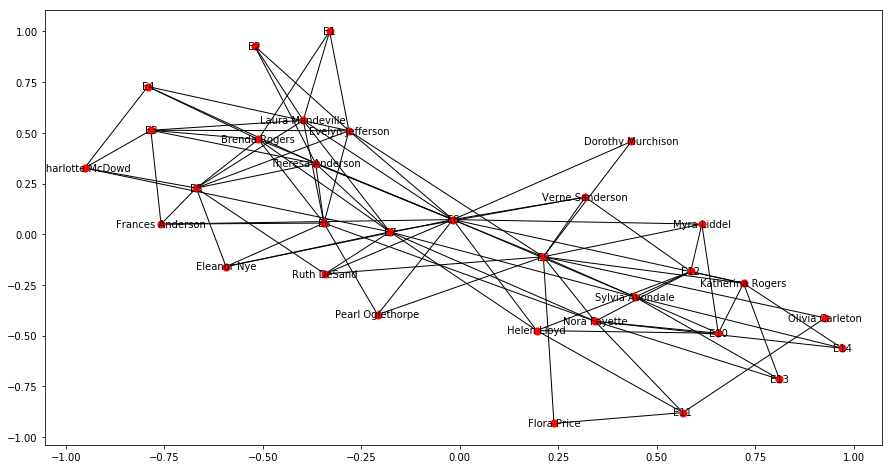

In [134]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

#Print node numbers 
print("Number of nodes:",G.number_of_nodes())
#Print edges number G.number_of_edges()
print("Number of edges:",G.number_of_edges())

### -- random infection

In [135]:
labels = init_labels(G)
rankedInfection = random_ranking(G)
#rankedInfection

In [136]:
rand_eval = evaluate_spread(G, payoff_dict, rankedInfection)

In [137]:
plot_distribution(rand_eval, "Random-Infection")

### -- closeness guided infection

In [138]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [139]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

In [140]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [141]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [142]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

In [143]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [144]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [145]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

In [146]:
plot_distribution(deg_eval, "Degree-guided")

## 2. Erdős-Rényi random graph

In [147]:
n = 100

### 2.1  $p<\frac{1}{n}$

In [148]:
G = nx.gnp_random_graph(n,1/(n*2))
pos = nx.spring_layout(G)
print("Average degree = {}".format(np.mean(list(map(lambda item:item[1], G.degree)))))

Average degree = 0.48


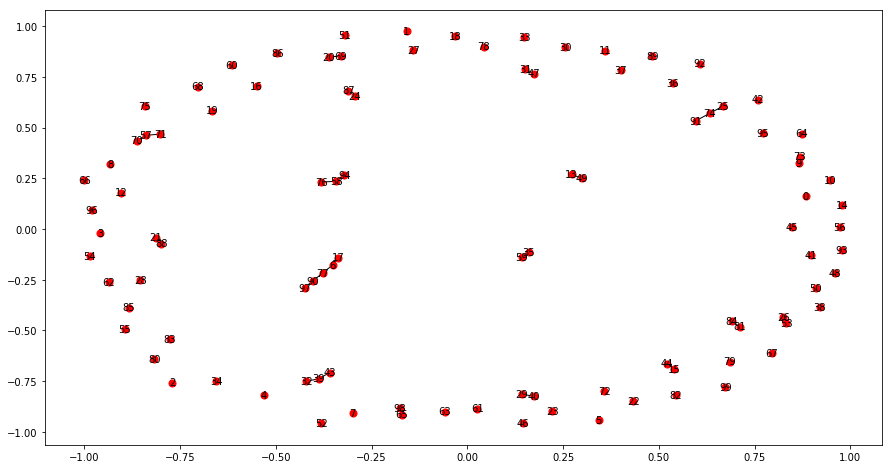

In [149]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random infection

In [150]:
labels = init_labels(G)
rankedInfection = random_ranking(G)
#rankedInfection

In [151]:
rand_eval = evaluate_spread(G, payoff_dict, rankedInfection)

In [152]:
plot_distribution(rand_eval, "Random-Infection")

### -- closeness guided infection

In [153]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [154]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

In [155]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [156]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [157]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

In [158]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [159]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [160]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

In [161]:
plot_distribution(deg_eval, "Degree-guided")

### 2.2  $\frac{1}{n}<p<\frac{\log{n}}{n}$

In [162]:
G = nx.gnp_random_graph(n,1/n)
pos = nx.spring_layout(G)
print("Average degree = {}".format(np.mean(list(map(lambda item:item[1], G.degree)))))

Average degree = 0.86


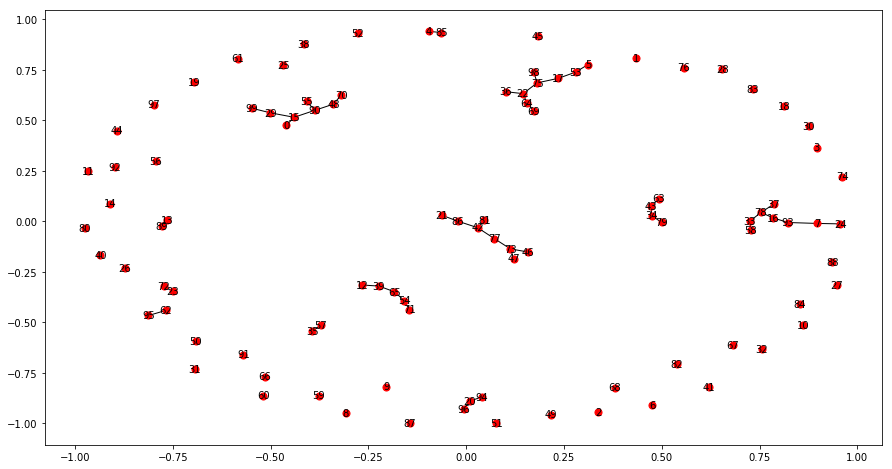

In [163]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random infection

In [164]:
labels = init_labels(G)
rankedInfection = random_ranking(G)
#rankedInfection

In [165]:
rand_eval = evaluate_spread(G, payoff_dict, rankedInfection)

In [166]:
plot_distribution(rand_eval, "Random-Infection")

### -- closeness guided infection

In [167]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [168]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

In [169]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [170]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [171]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

In [172]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [173]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [174]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

In [175]:
plot_distribution(deg_eval, "Degree-guided")

### 2.3  $p>\frac{\log{n}}{n}$

In [176]:
G = nx.gnp_random_graph(n,np.log(n*2)/n)
pos = nx.spring_layout(G)
print("log(n)={}, <k>={}".format(round(np.log(100),2), np.mean(list(map(lambda item:item[1], G.degree)))))

log(n)=4.61, <k>=5.52


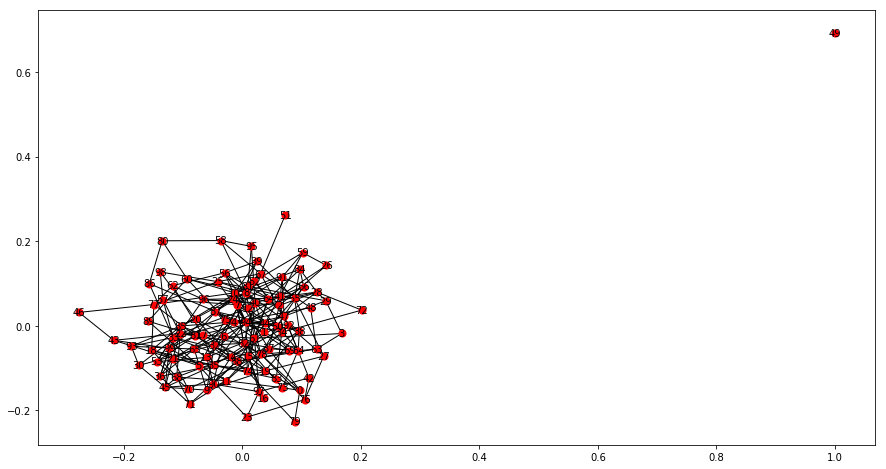

In [177]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random infection

In [178]:
labels = init_labels(G)
rankedInfection = random_ranking(G)
#rankedInfection

In [179]:
rand_eval = evaluate_spread(G, payoff_dict, rankedInfection)

In [180]:
plot_distribution(rand_eval, "Random-Infection")

### -- closeness guided infection

In [181]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [182]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

In [183]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [184]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [185]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

In [186]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [187]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [188]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

In [190]:
plot_distribution(deg_eval, "Degree-guided")

## 3. Power law network

In [191]:
G = nx.powerlaw_cluster_graph(n,1,0.5)
pos = nx.spring_layout(G)

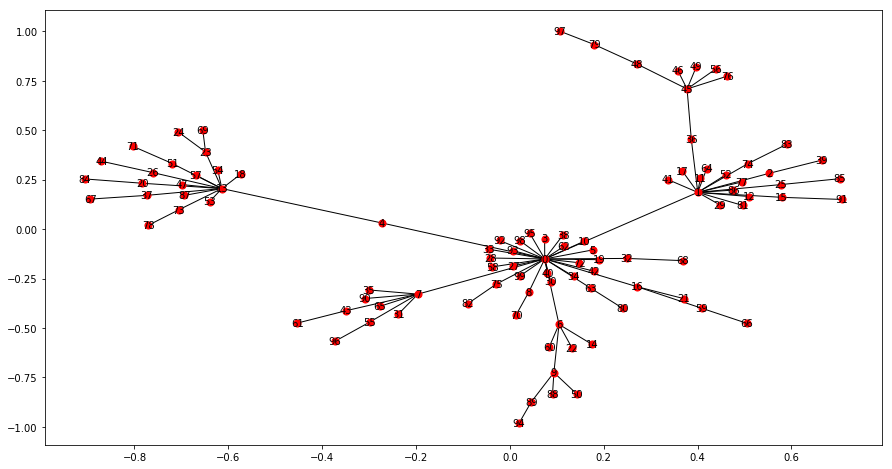

In [192]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random infection

In [193]:
labels = init_labels(G)
rankedInfection = random_ranking(G)
#rankedInfection

In [194]:
rand_eval = evaluate_spread(G, payoff_dict, rankedInfection)

In [195]:
plot_distribution(rand_eval, "Random-Infection")

### -- closeness guided infection

In [196]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [197]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

In [198]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [199]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [200]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

In [201]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [202]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [203]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

In [204]:
plot_distribution(deg_eval, "Degree-guided")

## 4. Real Graph - arXiv citations

In [ ]:
G = nx.Graph()
edges = nx.read_edgelist('../datasets/dataset.txt')
G.add_edges_from(edges.edges())
posTotal = nx.spring_layout(G)

In [ ]:
plt.figure(figsize=(15,10))
nx.draw_networkx(G, posTotal, font_size=0, node_size=50)

#Print node numbers 
print("Number of nodes:",G.number_of_nodes())
#Print edges number G.number_of_edges()
print("Number of edges:",G.number_of_edges())

### -- random infection

In [ ]:
labels = init_labels(G)
rankedInfection = random_ranking(G)
#rankedInfection

In [ ]:
rand_eval = evaluate_spread(G, payoff_dict, rankedInfection)

In [ ]:
plot_distribution(rand_eval, "Random-Infection")

### -- closeness guided infection

In [ ]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [ ]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

In [ ]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [ ]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [ ]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

In [ ]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [ ]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [ ]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

In [ ]:
plot_distribution(deg_eval, "Degree-guided")